In [1]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

### Convert the JSON file to masked images 


In [2]:
# ###########################################
# import labelme
# from PIL import Image, ImageDraw
# import json
# import os

# # Function to load and parse Labelme JSON file
# def load_labelme_json(json_file):
#     with open(json_file, 'r') as f:
#         data = json.load(f)
#     return data

# # Function to convert Labelme annotations to masked image
# def convert_labelme_to_masked_png(data, labels):
#     # Get the image height and width
#     img_height = data['imageHeight']

#     img_width = data['imageWidth']

#     # Create a blank image with a black background
#     image = Image.new('L', (img_width, img_height), 0)
#     draw = ImageDraw.Draw(image)

#     # Iterate through the shapes in the Labelme data
#     for shape in data['shapes']:
#         label = shape['label']
#         mask = labelme.utils.shape_to_mask(
#             (img_height, img_width),
#             shape['points'],
#             shape_type=shape['shape_type']
#         )

#         # Convert the binary mask to PIL ImageDraw format
#         mask_image = Image.fromarray(mask.astype('uint8') * 255)

#         # Get the label index
#         label_index = labels.index(label)

#         # Draw the mask on the image using the label index as the color
#         draw.bitmap((0, 0), mask_image, fill=label_index)

#     return image

# # Function to save the masked image as a PNG file
# def save_masked_image(image, output_file):
#     image.save(output_file)

# # Convert Labelme JSON files to masked PNGs
# def convert_labelme_files(json_dir, output_dir, labels):
#     # Create the output directory if it doesn't exist
#     os.makedirs(output_dir, exist_ok=True)

#     # Process each JSON file in the directory
#     for filename in os.listdir(json_dir):
#         if filename.endswith('.json'):
#             json_file = os.path.join(json_dir, filename)
#             output_file = os.path.join(output_dir, filename.replace('.json', '.png'))

#             # Load and parse the Labelme JSON file
#             data = load_labelme_json(json_file)

#             # Convert Labelme annotations to a masked image
#             masked_image = convert_labelme_to_masked_png(data, labels)

#             # Save the masked image as a PNG file
#             save_masked_image(masked_image, output_file)
#             print(f"Converted {json_file} to {output_file}")

# # Define the labels in the JSON files
# labels = ['_background_', 'background', 'land', 'road', 'road_affected', 'house_affected', 'water', 'landslide', 'house']

# # Directory paths for JSON files and output masked PNGs
# # json_dir = 'D:\\Research\\3\\json'
# # output_dir = 'D:\\Research\\3\\json\\ahsan'

# # # Convert Labelme JSON files to masked PNGs
# # convert_labelme_files(json_dir, output_dir, labels)


<a name='2'></a>
## 2 - Load and Split the Data

In [3]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I\\O (e.g. pd.read_csv)

import imageio

import matplotlib.pyplot as plt
%matplotlib inline
path = ''
image_path = os.path.join(path, 'D:\\Research\\data labelling\\jpegs\\')
mask_path = os.path.join(path, 'D:\\Research\\data labelling\\Output_masks\\')
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

In [4]:
len(image_list)

447

### Check out the some of the unmasked and masked images from the dataset:

C:\Users\Pc\AppData\Local\Temp\ipykernel_20608\680069655.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_list[N])
C:\Users\Pc\AppData\Local\Temp\ipykernel_20608\680069655.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_list[N])


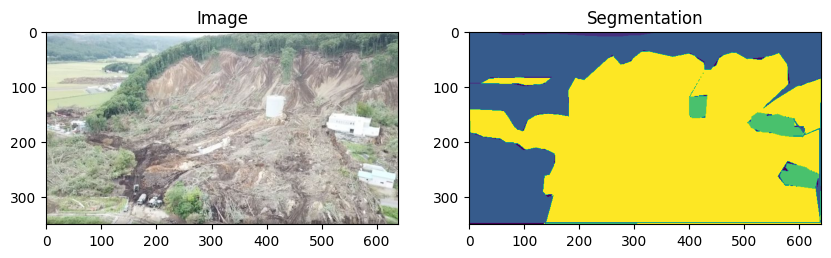

In [5]:
N = 6
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
fig, arr = plt.subplots(1, 2, figsize=(10, 5))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask)
arr[1].set_title('Segmentation')
plt.show()


<a name='2-1'></a>
### 2.1 - Split Your Dataset into Unmasked and Masked Images

In [6]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'D:\\Research\\data labelling\\jpegs\\SlideNet (100).jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'D:\\Research\\data labelling\\Output_masks\\SlideNet (100).png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'D:\\Research\\data labelling\\jpegs\\SlideNet (101).jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'D:\\Research\\data labelling\\Output_masks\\SlideNet (101).png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'D:\\Research\\data labelling\\jpegs\\SlideNet (102).jpg'>, <tf.Tensor: shape=(), dtype=string, numpy=b'D:\\Research\\data labelling\\Output_masks\\SlideNet (102).png'>)


In [7]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'D:\\Research\\data labelling\\jpegs\\SlideNet (100).jpg', shape=(), dtype=string)
tf.Tensor(b'D:\\Research\\data labelling\\Output_masks\\SlideNet (100).png', shape=(), dtype=string)


<a name='2-2'></a>
### 2.2 - Preprocess Your Data

In [8]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    input_image = input_image / 255.

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

### The U-Net network has 23 convolutional layers in total. 

In [11]:
from tensorflow.keras.layers import *
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):

    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(inputs)
    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(conv)
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
         
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D(2,strides=2)(conv)
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [12]:
# Only to test the pull request

# input_size=(96, 128, 3)
# n_filters = 32
# inputs = Input(input_size)
# cblock1 = conv_block(inputs, n_filters * 1)
# model1 = tf.keras.Model(inputs=inputs, outputs=cblock1)

# output1 = [['InputLayer', [(None, 96, 128, 3)], 0],
#             ['Conv2D', (None, 96, 128, 32), 896, 'same', 'relu', 'HeNormal'],
#             ['Conv2D', (None, 96, 128, 32), 9248, 'same', 'relu', 'HeNormal'],
#             ['MaxPooling2D', (None, 48, 64, 32), 0, (2, 2)]]

# print('Block one:')
# for layer in summary(model1):
#     print(layer)

# comparator(summary(model1), output1)

# inputs = Input(input_size)
# cblock1 = conv_block(inputs, n_filters * 32, dropout_prob=0.1, max_pooling=True)
# model2 = tf.keras.Model(inputs=inputs, outputs=cblock1)

# output2 = [['InputLayer', [(None, 96, 128, 3)], 0],
#             ['Conv2D', (None, 96, 128, 1024), 28672, 'same', 'relu', 'HeNormal'],
#             ['Conv2D', (None, 96, 128, 1024), 9438208, 'same', 'relu', 'HeNormal'],
#             ['Dropout', (None, 96, 128, 1024), 0, 0.1],
#             ['MaxPooling2D', (None, 48, 64, 1024), 0, (2, 2)]]
           
# print('\nBlock 2:')   
# for layer in summary(model2):
#     print(layer)
    
# comparator(summary(model2), output2)

In [13]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,# Kernel size
                 strides=2,
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    
    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(merge)
    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(conv)
    
    return conv

In [14]:

def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=9):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # Contracting Path (encoding)
    # Add a conv_block with the inputs of the unet_ model and n_filters
    ### START CODE HERE
    cblock1 = conv_block(inputs=inputs, n_filters=n_filters*1)
    # print(cblock1[0].shape)
    # Chain the first element of the output of each block to be the input of the next conv_block. 
    # Double the number of filters at each new step
    cblock2 = conv_block(inputs=cblock1[0], n_filters=n_filters*2)
    cblock3 = conv_block(inputs=cblock2[0], n_filters=n_filters*4)
    # Include a dropout of 0.3 for this layer
    cblock4 = conv_block(inputs=cblock3[0], n_filters=n_filters*8,dropout_prob=0.3)
    # Include a dropout of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(inputs=cblock4[0], n_filters=n_filters*16,dropout_prob=0.3, max_pooling=False) 
    ### END CODE HERE
    
    # Expanding Path (decoding)
    # Add the first upsampling_block.
    # From here,at each step, use half the number of filters of the previous block 
    # Use the cblock5[0] as expansive_input and cblock4[1] as contractive_input and n_filters * 8
    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters*8)
    # Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    # Note that you must use the second element of the contractive block i.e before the maxpooling layer. 
    
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters*1)

    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    ### START CODE HERE
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    ### END CODE HERE
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

# UNET With pretrained MobileNet

In [15]:
def model():
    inputs = Input(shape=(96, 128, 3), name="input_image")
    # encoder = tf.keras.applications(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    
    encoder = tf.keras.applications.MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    for layer in encoder.layers:
        layer.trainable = False
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
    f = [16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(9, (1, 1), padding="same")(x)
    # x = Activation("softmax")(x)
    
    model = Model(inputs, x)
    return model

In [16]:
# model2.summary()    

In [17]:
model2 = unet_model()

input_shape = (1, 96, 128, 3)  # Batch size of 1, image size (96, 128), 3 channels (RGB)
random_tensor = np.random.rand(*input_shape)

# Create the model

# Make predictions
output_mask = model2(random_tensor)

# Print the shape of the output mask
print("Output Mask Shape:", output_mask.shape)

Output Mask Shape: (1, 96, 128, 9)


<a name='3-5'></a>
### 3.5 - Set Model Dimensions

In [18]:
img_height = 96
img_width = 128
num_channels = 3

# unet = unet_model((img_height, img_width, num_channels))

### Check out the model summary below! 

In [19]:
# unet.summary()

In [20]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

<a name='3-7'></a>
### 3.7 - Dataset Handling

Below, define a function that allows you to display both an input image, and its ground truth: the true mask. The true mask is what your trained model output is aiming to get as close to as possible. 

In [21]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(771, 501, 1)
(434, 640, 1)
(426, 640, 1)
(360, 640, 1)


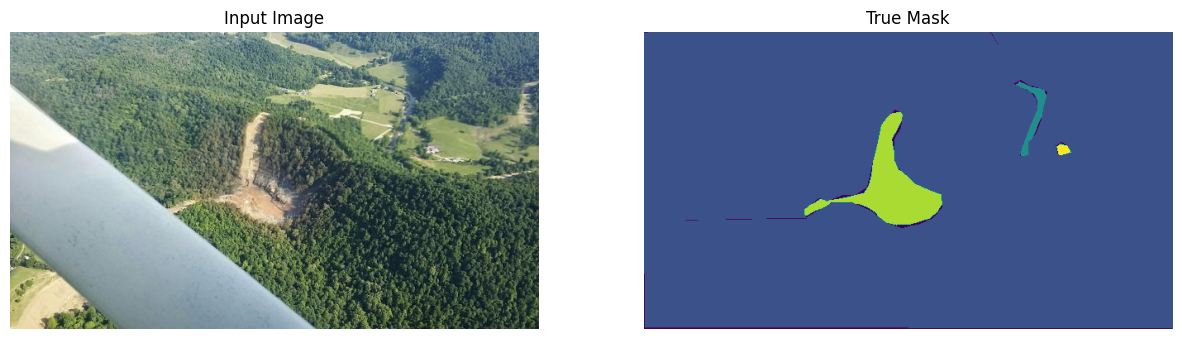

In [22]:
for image, mask in image_ds.take(4):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(96, 128, 1)
(96, 128, 1)
(96, 128, 1)
(96, 128, 1)


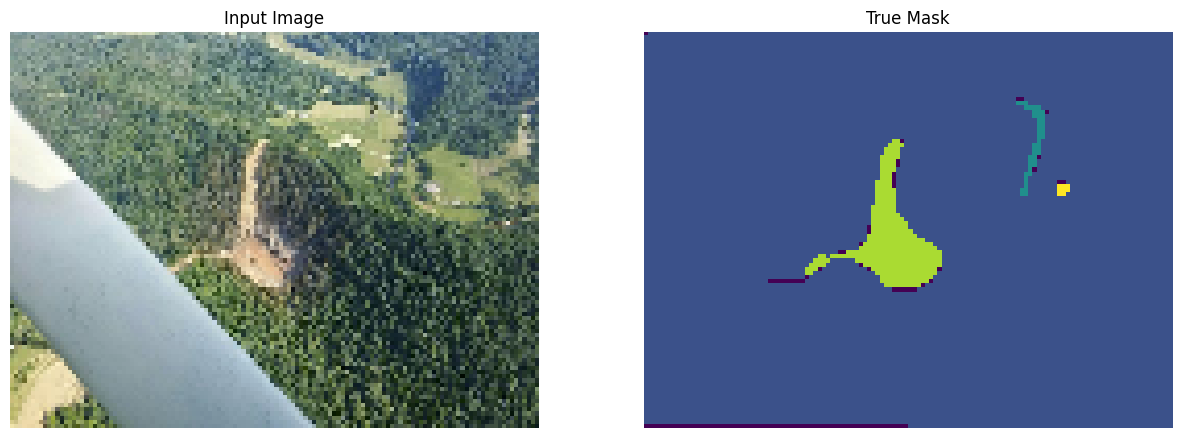

In [23]:
for image, mask in processed_image_ds.take(4):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

<a name='4'></a>
## 4 - Train the Model

In [28]:
from keras.callbacks import ModelCheckpoint
checkpoint_filepath = 'best_model_mobile.h5'

# Define the ModelCheckpoint callback to save the best model based on validation accuracy
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='accuracy',  # You can change this to another metric if needed
    mode='max',  # 'max' if monitoring accuracy, 'min' if monitoring loss
    save_best_only=True,
)




EPOCHS = 100
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 16
processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)


(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))


In [ ]:

# model_history = unet.fit(train_dataset, epochs=EPOCHS  , )
model_history = model2.fit(train_dataset, epochs=EPOCHS, callbacks=[model_checkpoint_callback])
# model_history = unet.fit(train_dataset, epochs=EPOCHS, callbacks=[model_checkpoint_callback])

In [24]:
model2.load_weights("best_model_mobile.h5")

<a name='4-1'></a>
### Create Predicted Masks 

Now, define a function that uses `tf.argmax` in the axis of the number of classes to return the index with the largest value and merge the prediction into a single image:

In [25]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

<a name='4-2'></a>
### 4.2 - Plot Model Accuracy

Let's see how your model did! 

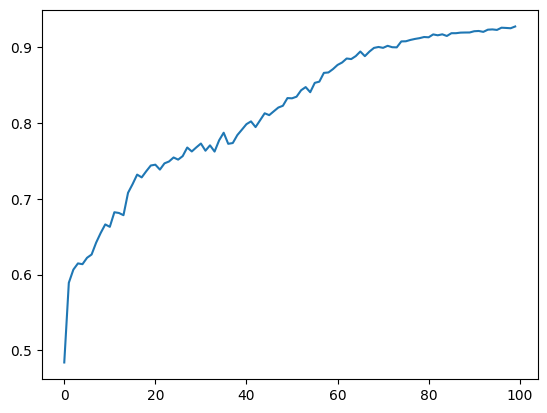

In [25]:
plt.plot(model_history.history["accuracy"])

<a name='4-3'></a>
### 4.3 - Show Predictions 

Next, check your predicted masks against the true mask and the original input image:

In [26]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model2.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(model2.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 4s 4s/step


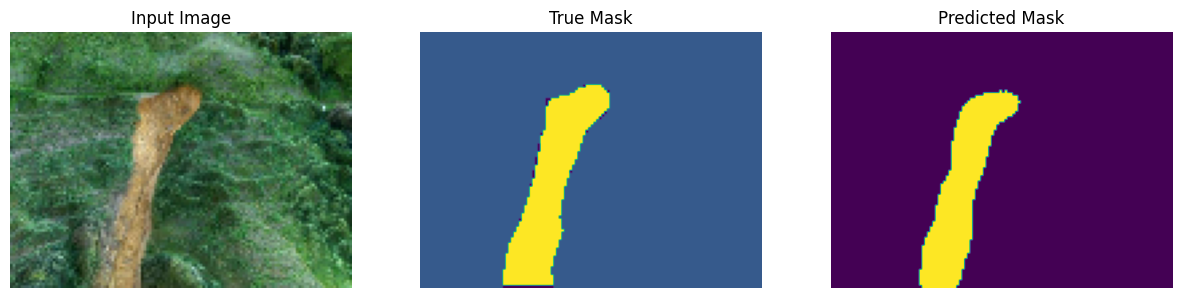

1/1 [==============================] - 0s 80ms/step


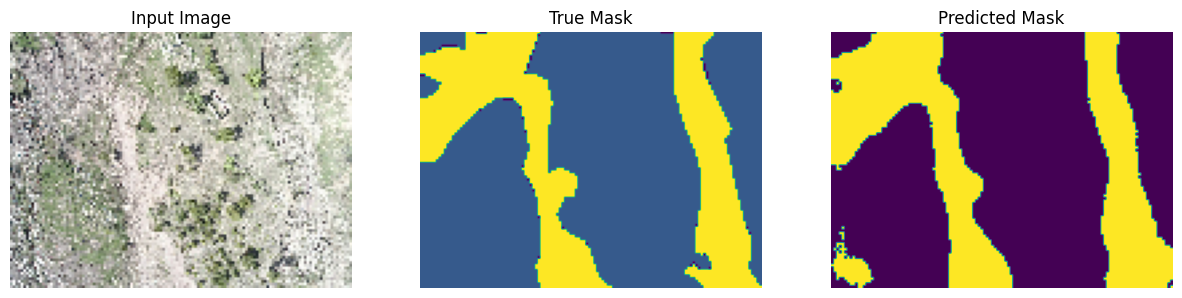

1/1 [==============================] - 0s 50ms/step


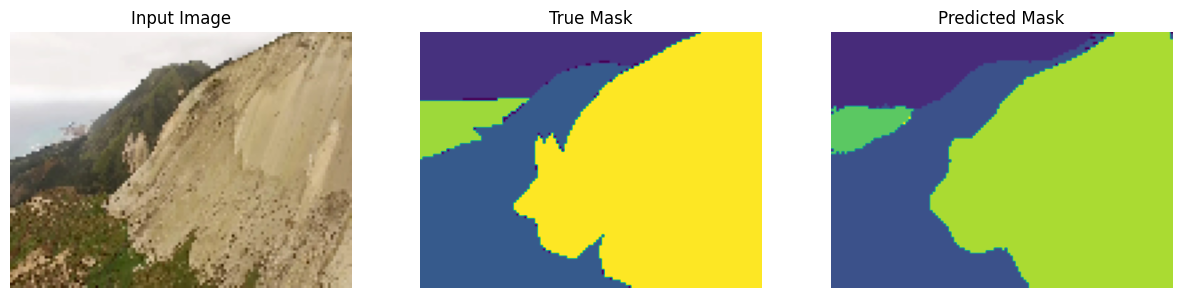

In [29]:
show_predictions(train_dataset, 3)

(1, 96, 128, 3)
1/1 [==============================] - 0s 51ms/step
(1, 96, 128, 9)
(96, 128, 1)


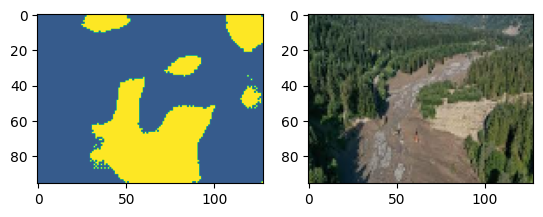

In [31]:
path = "./test2.jpeg"
img = tf.io.read_file(path)
img = tf.image.decode_png(img, channels=3)
img = tf.image.convert_image_dtype(img, tf.float32)
img = tf.image.resize(img, (96, 128))
img = img[tf.newaxis, ...]
print(img.shape)
pred_mask = model2.predict(img)
print(pred_mask.shape)
pred_mask = create_mask(pred_mask)
print(pred_mask.shape)
plt.subplot(1, 2, 1)
plt.imshow(pred_mask)
# plt.imshow(pred_mask[:,:,:,8][0])
# print(pred_mask[:,:,1][0].shape)
plt.subplot(1, 2, 2)

plt.imshow(img[0])
# display([img[0], pred_mask])


(1, 96, 128, 3)
1/1 [==============================] - 0s 84ms/step
(1, 96, 128, 9)
(96, 128, 1)


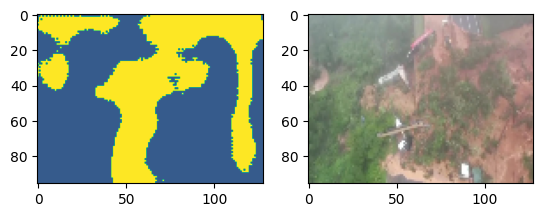

In [32]:
path = "./test.jpg"
img = tf.io.read_file(path)
img = tf.image.decode_png(img, channels=3)
img = tf.image.convert_image_dtype(img, tf.float32)
img = tf.image.resize(img, (96, 128))
img = img[tf.newaxis, ...]
print(img.shape)
pred_mask = model2.predict(img)
print(pred_mask.shape)
pred_mask = create_mask(pred_mask)
print(pred_mask.shape)
plt.subplot(1, 2, 1)
plt.imshow(pred_mask)
# plt.imshow(pred_mask[:,:,:,8][0])
# print(pred_mask[:,:,1][0].shape)
plt.subplot(1, 2, 2)

plt.imshow(img[0])
# display([img[0], pred_mask])
